# Odhad regresních koeficientů pomocí bayesovské řídké regrese


In [2]:
import numpy as np
import matplotlib.pylab as plt
np.set_printoptions(precision=2)
import scipy.io as sio

Nejprve si nagenerujeme data dle modelu
$$
\mathbf{y} = X\boldsymbol{\beta}+\mathbf{e}
$$

<ipython-input-3-9d6d5c19ef4d>:29: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X),interpolation='none')


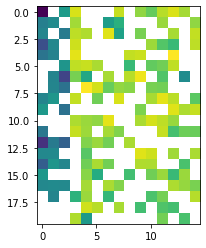

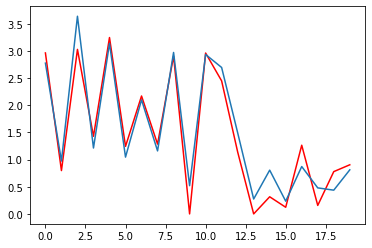

In [3]:
p = 20 ### pocet mereni
n = 15 # pocet regresnich koeficientu

if 0:
    # matice regresnich koeficientu
    X = np.random.randn(p,n)
    ind = X < 0
    X[ind] = 0
    # tento vektor budeme odhadovat
    beta_true = np.array([0,0,0,1,0,0,1,1,1,0,0,0,0,0,0])

    # chceme spatnou podminenost
    ind = [0,1,2]
    X[:,ind] = X[:,ind]/100
    
    # chceme sum
    y = np.transpose(X@beta_true + 0.3*np.random.randn(p)) ### sila sumu je volitelna
    y.shape = (p,1)
    ind2 = y<0
    y[ind2] = 0
    #print(y)
else:
    # data pouzita v prednasce
    X = sio.loadmat("lin_reg_data.mat")["X"]
    y = sio.loadmat("lin_reg_data.mat")["y"]
    beta_true = sio.loadmat("lin_reg_data.mat")["beta_true"]
    #print(y)

plt.imshow(np.log(X),interpolation='none')

#---------------------------------------------
# vykreslete do jednoho grafu mereni a generovana data
#---------------------------------------------
plt.figure()
plt.plot(X@beta_true,color='red')
plt.plot(y)

## Bayesovská sparse regression

Připomeňme soustavu implicitních rovnic (odvozenou na přednášce) pro aposteriorní rozdělení $\tilde{f}(\boldsymbol{\beta}|\mathbf{y})=\mathcal{N}(\mu_\boldsymbol{\beta},\Sigma_\boldsymbol{\beta})$, $\tilde{f}(\omega|\mathbf{y})=\mathcal{G}(c,d)$ a $\tilde{f}(v_j|\mathbf{y})=\mathcal{G}(a_j,b_j), \forall j,$ s tvarovacími parametry:

\begin{align}
\Sigma_{\boldsymbol{\beta}}= & \left(\widehat{\omega}X^{T}X+diag(\widehat{\mathbf{v}})\right)^{-1}\\
\mu_{\boldsymbol{\beta}}= & \Sigma_{\boldsymbol{\beta}}\widehat{\omega}X^{T}\mathbf{y}\\
c= & c_{0}+\frac{p}{2}\\
d= & d_{0}+\frac{1}{2}\left(\mathbf{y}^{T}\mathbf{y}-2\mathbf{y}^{T}X\widehat{\boldsymbol{\beta}}+\text{trace}[\widehat{\boldsymbol{\beta}\boldsymbol{\beta}^{T}}X^{T}X]\right)\\
a_j &= a_0 + \frac{1}{2} \\
b_j &= b_0 + \frac{1}{2}(\widehat{\boldsymbol{\beta}\boldsymbol{\beta}^{T}})_{j,j}
\end{align}
...a příslušné momenty:
\begin{align}
\widehat{\boldsymbol{\beta}} &= \mu_{\boldsymbol{\beta}}\\
\widehat{\boldsymbol{\beta}\boldsymbol{\beta}^T} &= \mu_{\boldsymbol{\beta}}\mu_{\boldsymbol{\beta}}^T + \Sigma_{\boldsymbol{\beta}}\\
\widehat{\omega} &= \frac{c}{d} \\
\widehat{v}_j &= \frac{a_j}{b_j}
\end{align}

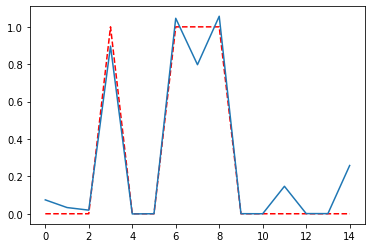

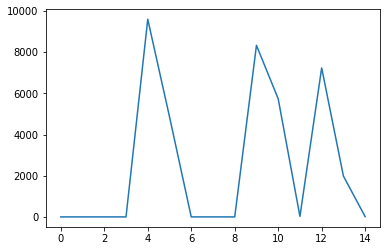

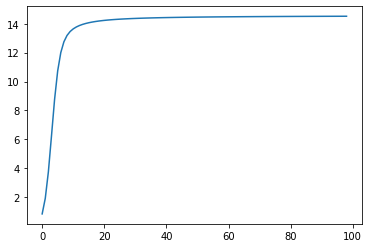

In [7]:
# apriorni konstanty
c0 = 1e-10
d0 = 1e-10
a0 = 1e-10
b0 = 1e-10

# startovaci hodnoty
hat_v = np.ones(n)
hat_omega = 1/np.ndarray.max(X)
hist_omega = []

for i in range(1,100):
    #---------------------------------------------
    # spocitejte tvarovaci parametry a momenty \beta
    #---------------------------------------------
    si_beta = np.linalg.inv(hat_omega*X.T@X + np.diag(hat_v))
    mu_beta = si_beta@(hat_omega*X.T@y)
    hat_beta = mu_beta
    hat_bbt = mu_beta@mu_beta.T + si_beta
    
    #---------------------------------------------
    # spocitejte tvarovaci parametry a momenty vektoru "v"
    #---------------------------------------------
    a = a0 + 1/2*np.ones(n)
    b = b0 + 1/2*np.diag(hat_bbt)
    hat_v = a/b
    
    #---------------------------------------------
    # spocitejte tvarovaci parametry a momenty \omega (staci zkopirovat z predchoziho)
    #---------------------------------------------
    c = c0 + p/2
    d = d0 + 1/2*(y.T@y) - y.T@X@hat_beta + 1/2*np.trace(hat_bbt@X.T@X)
    hat_omega = c/d
    hist_omega = np.append(hist_omega,hat_omega)

    
# vysledek ulozime a vytiskneme
beta_VBsparse = hat_beta
    
plt.plot(beta_true,color='red',linestyle='dashed')
plt.plot(beta_VBsparse)

plt.figure()
plt.plot(hat_v)

plt.figure()
plt.plot(hist_omega)

## Srovnáme si to s výsledkem regularizace pomocí LASSO

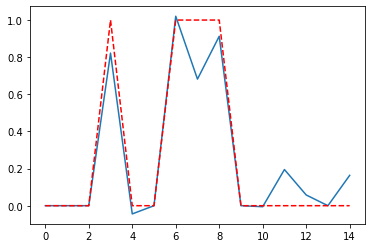

In [5]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1e-2)

lasso.fit(X, y)

beta_lasso = lasso.coef_

plt.plot(beta_lasso)
plt.plot(beta_true,color='red',linestyle='dashed')

# Ukázka na reálném případě č. 1

K dispozici máte data z European Tracer EXperimentu, kdy byla vypouštěna po danou dobu a s danou intenzitou jistá látka, která byla následně měřena v rámci Evropy:
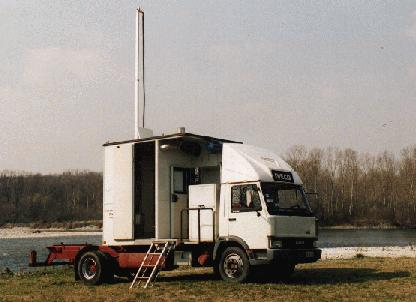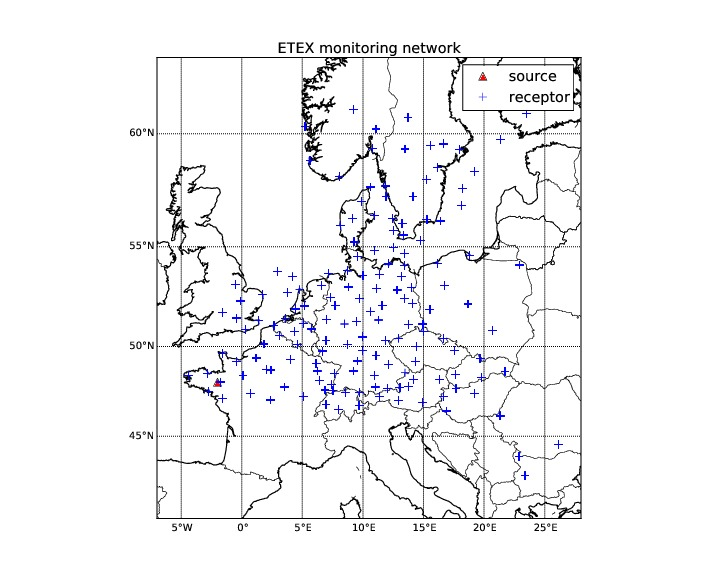

## Data

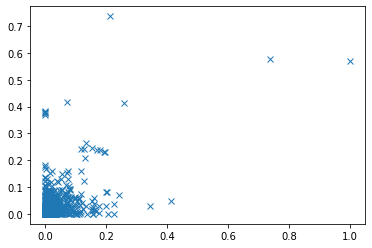

In [2]:
X = sio.loadmat("data_ETEX.mat")["X"]
y = sio.loadmat("data_ETEX.mat")["y"]
beta_true = sio.loadmat("data_ETEX.mat")["beta_true"]
    
(p,n) = np.shape(X)

#---------------------------------------------
# vykreslete do grafu (jako jednotlive body) zavislost mereni y a teoreticky spravne rekonstrukce X*beta_true
# co z toho muzete usoudit o kvalite predlozenych dat?
#---------------------------------------------
plt.plot(y,X@beta_true,'x')

## Nejmenší čtverce s Tichonovovou regularizací

Zkuste naladit Tichonovovu regularizaci tak, aby jste se přiblížili správnému řešení.
- ručně
- pomocí L-křivky

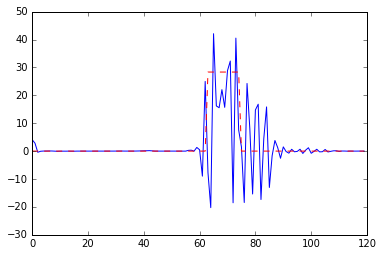

In [66]:
alpha = np.power(10,-5.5) ### regularizacni koeficient
beta_tich = np.zeros(n)
#---------------------------------------------
# spocitejte a vykreslete reseni pomoci nejmensich ctvercu s Tichonovou regularizaci
#---------------------------------------------
beta_tich = np.linalg.inv(X.T@X + alpha*np.eye(n))@X.T@y

plt.plot(beta_tich)
plt.plot(beta_true,color='red',linestyle='dashed')

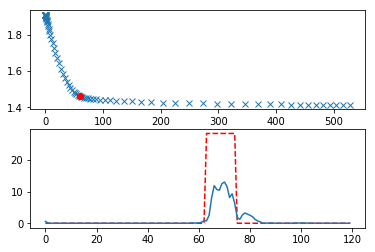

In [4]:
norm_b = []
norm_yXb = []

#---------------------------------------------
# spocitejte pro danny rozsah normy vhodne pro vytvoreni L-krivku
# L-krivku vykreslete a vyberte vhodne alpha
#---------------------------------------------
for i in range(-80,0):
    alpha = np.power(10,i/10)
    beta_tich = np.linalg.inv(X.T@X + alpha*np.eye(n))@X.T@y
    norm_b = np.append(norm_b,np.linalg.norm(beta_tich))
    norm_yXb = np.append(norm_yXb,np.linalg.norm(y - X@beta_tich))

    
plt.subplot(211)
plt.plot(norm_b,norm_yXb,'x')
plt.plot(norm_b[35],norm_yXb[35],'ro')

#---------------------------------------------
# vybrane alpha pouzijte a vysledek vykreslete
#---------------------------------------------
beta_tich_optim = np.linalg.inv(X.T@X + np.power(10,-3.5)*np.eye(n))@X.T@y

plt.subplot(212)
plt.plot(beta_true,color='red',linestyle='dashed')
plt.plot(beta_tich_optim)

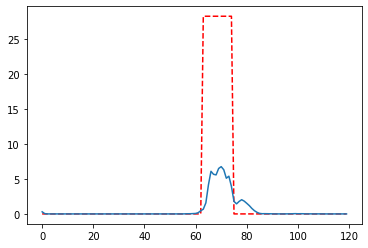

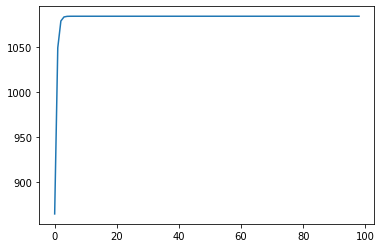

In [3]:
c0 = 1e-10
d0 = 1e-10

# trasovani vyvoje regularizacniho parametru
hat_omega = 1/np.ndarray.max(X)
hist_omega = []

for i in range(1,100): # pocet interaci
    #---------------------------------------------
    # tvarovaci parametry a momenty \beta
    #---------------------------------------------
    si_beta = np.linalg.inv(hat_omega*X.T@X + np.eye(n))
    mu_beta = si_beta@(hat_omega*X.T@y)
    hat_beta = mu_beta
    hat_bbt = mu_beta@mu_beta.T + si_beta
    
    #---------------------------------------------
    # tvarovaci parametry a momenty \omega
    #---------------------------------------------
    c = c0 + p/2
    d = d0 + 1/2*(y.T@y) - y.T@X@hat_beta + 1/2*np.trace(hat_bbt@X.T@X)
    hat_omega = c/d
    hist_omega = np.append(hist_omega,hat_omega)

# vysledek ulozime a vytiskneme
beta_VBridge = hat_beta
    
plt.plot(beta_true,color='red',linestyle='dashed')
plt.plot(beta_VBridge)

plt.figure()
plt.plot(hist_omega)

## Použití bayesian sparse regression

Zde je nutné použít nečistý trik pro pozitivitu řešení (na přednášce jsme si říkali, jak to udělat správně - pomocí ořezaného normálního rozdělení - na to tu ale nemáme kapacitu).
- v každé iteraci ořízněte záporné hodnoty $\mu_\beta$ na 0

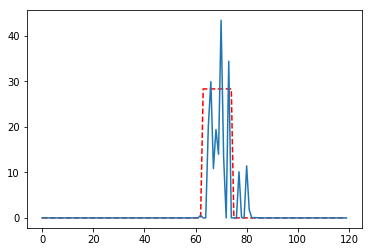

In [7]:
c0 = 1e-10
d0 = 1e-10
a0 = 1e-10
b0 = 1e-10

hat_v = np.ones(n)
hat_omega = 1/np.ndarray.max(X.T@X)

#---------------------------------------------
# a) pouzijte bayesian sparse regression z prvni casti cviceni
#
# b) modifikujte vypocet tak, aby v \beta byly jen kladne hodnoty
#    (napr. vhodnym "nulovanim")
#---------------------------------------------

for i in range(1,100):
    #print(i)
    si_beta = np.linalg.inv(hat_omega*X.T@X + np.diag(hat_v))
    mu_beta = si_beta@(hat_omega*X.T@y)
    ind = mu_beta<0
    mu_beta[ind] = 0
    hat_beta = mu_beta
    hat_bbt = mu_beta@mu_beta.T + si_beta
    
    a = a0 + 1/2*np.ones(n)
    b = b0 + 1/2*np.diag(hat_bbt)
    hat_v = a/b
    
    c = c0 + p/2
    d = d0 + 1/2*(y.T@y) - y.T@X@hat_beta + 1/2*np.trace(hat_bbt@X.T@X)
    hat_omega = c/d
    
beta_VBsparse = hat_beta
    
plt.plot(beta_true,color='red',linestyle='dashed')
plt.plot(beta_VBsparse)